In [ ]:
!pip install qsharp --quiet
!pip install pyscf --quiet
!pip install openfermion --quiet
!pip install openfermionpyscf --quiet
!pip install cirq --quiet

: 

In [1]:
import numpy as np
import qsharp
import matplotlib.pyplot as plt
from scipy.sparse import linalg as lg
import cirq
from openfermion import *
from openfermionpyscf import *
from math import prod
import math
from pyscf import scf, gto
from pyscf.tools import fcidump

## Generate Molecular hamiltonian


In [ ]:
# geometry = [('H', (0., 0., 0.)), ('H', (0., 0.,0.782))]
geometry = [('He', (0., 0., 1.0)), ('He', (0., 0.,0.0))]
# geometry = [('H',(-1.43082,0.00000,-0.88630)),('H',(1.43082,0.00000,-0.88630)), ('O',(0.00000, 0.00000,0.22157))]
# geometry = [('Be',(0.00000,0.00000,0.00000))]


basis = 'sto-3g' #'cc-pVDZ' #'sto-3g'  #6-31g
charge = 0
multiplicity = 1
def set_mol():
    mol = gto.M(atom=geometry)
    mol.basis = basis
    mol.charge = 0
    mol.multiplicity = 1
    mol.build()
    return mol

# Define main function
mol = set_mol()
rhf = scf.RHF(mol)
energy = rhf.kernel()

converged SCF energy = -5.43302050115388


In [3]:
no_of_el = mol.nelectron
hamiltonian_0 = generate_molecular_hamiltonian(
    geometry=geometry,basis= basis, multiplicity=multiplicity,charge= charge
)
no_of_qubits = hamiltonian_0.n_qubits
hamiltonian_ferm_op = get_fermion_operator(hamiltonian_0)
hamiltonian = jordan_wigner(hamiltonian_ferm_op)
hamiltonian.compress()
ordered_hamiltonian = sorted(list(hamiltonian.terms.keys()))

## Numerical Eignevalue

In [4]:
hamiltonian_sparse = get_sparse_operator(hamiltonian)
eigenvalues, _ = lg.eigsh(hamiltonian_sparse, k=no_of_qubits-1, which='SA')  # Largest eigenvalue
smallest_eigenvalue = eigenvalues[0]
print(f"Smallest Eigenvalue: {smallest_eigenvalue}")

Smallest Eigenvalue: -5.433020501153877


## Convert fcidump to pauli operator hamiltonian

In [5]:
scale = 0
id_coef = 0
for term in ordered_hamiltonian:
    if(len(term)>0):
        scale += abs(hamiltonian.terms[term])
    else:
        id_coef += hamiltonian.terms[term]
# scale_ham = np.pi/scale
# scaled_ham = -scale_ham * pauli_op
# pauli_hamiltonian = scaled_ham.data
# print(scale_ham)
print(id_coef)



coefficients = []
indexs = []
pauli_nums = []
pauli_strings = []
for term in ordered_hamiltonian:
    if(len(term) > 0):
        if(type(hamiltonian.terms[term]) == np.complex_ or type(hamiltonian.terms[term]) == complex):
            if(hamiltonian.terms[term].imag == 0):
              coefficients.append(hamiltonian.terms[term].real)
            elif(hamiltonian.terms[term].real == 0):
              coefficients.append(hamiltonian.terms[term].imag)
            else:
              coefficients.append(np.arctan2(hamiltonian.terms[term].imag,hamiltonian.terms[term].real))
        else:
            coefficients.append(float(hamiltonian.terms[term]))
        idxslist = []
        paulistrlist = []
        paulinumlist = []
        for j in term:
           idxslist.append(j[0])
           paulistrlist.append(j[1])
           if(j[1]=="Z"):
               paulinumlist.append(3)
           elif(j[1] == "X"):
               paulinumlist.append(1)
           elif(j[1] == "Y"):
               paulinumlist.append(2)
        indexs.append(idxslist)
        pauli_nums.append(paulinumlist)
        pauli_strings.append(paulistrlist)

-2.6892210114617368


In [6]:
# print(coefficients)
# print(indexs)
# print(pauli_nums)
# print(pauli_strings)

## Qsharp Code

In [7]:
import qsharp


In [ ]:
%%qsharp

// namespace Microsoft.Quantum.Applications.trotter {
    open Microsoft.Quantum.Measurement;
    open Microsoft.Quantum.Convert;
    open Microsoft.Quantum.Math;
    open Microsoft.Quantum.Arrays;
    open Microsoft.Quantum.Diagnostics;
    open Microsoft.Quantum.Intrinsic;
    open Microsoft.Quantum.Canon;
    open Microsoft.Quantum.Random;

// Custom Data structure for hamiltonian terms
    newtype hamiltonian = (
        coef : Double[],
        paulistr : Int[][],
        indices : Int[][]
    );

// Intialized fucntion
   // ttstep = No of trotter steps
   // torder = First order trotterization
   // time = Evolution time

    operation trotterham(orbs:Int,trottersteps:Int,ancilia:Int, particles:Int,ev_time:Double, ham:hamiltonian ) : Result[] {
        use Ancilia_Register = Qubit[ancilia]; // Not used, so set to 0, useful for further implementation
        use Sim_Register = Qubit[orbs]; // Simulation register
        ApplyToEach(H,Ancilia_Register);

        for i in 1..MinI(particles,orbs){
           X(Sim_Register[i-1])
        }

        // DumpRegister(Sim_Register);
        trotterstep(trottersteps,ev_time,1,ham::paulistr,ham::indices,ham::coef,Sim_Register,Ancilia_Register,ancilia); // call trotterstep function
        Adjoint ApplyQFT(Ancilia_Register);
        mutable resultArray = [Zero, size = ancilia];
        let result = MeasureAllZ(Ancilia_Register);
        for i in IndexRange(Ancilia_Register) {
            set resultArray w/= i <- M(Ancilia_Register[i]);
        }
        // DumpRegister(Sim_Register);
        ResetAll(Sim_Register);
        ResetAll(Ancilia_Register);
        return resultArray;
        // return result;
    }

// Trotter step fucntion to call circuit builder function
    operation trotterstep(tstep:Int,time:Double,torder:Int,paulistrings:Int[][],
    indexs:Int[][],coefficient:Double[],Sregister:Qubit[],Aregister:Qubit[],ancs:Int):Unit{
        for anc in 1..ancs {
            let p = ancs - (anc -1);
            for i in 1..tstep {
                for each_anc in 1..2^(anc-1) {
                    for j in IndexRange(coefficient) {
                        // create a gate parameter using (coefficient * (time evolution/trotter step))
                        let angle =  coefficient[j]*(time/IntAsDouble(tstep));
                        ham_to_circuit(j,paulistrings,indexs,angle,Sregister,Aregister,p) // Circuit builder
                    }
                }
            }
        }
    }

// Circuit builder
// circuit design is done using https://arxiv.org/pdf/1001.3855

//--------------------------convert  Hmailtonian into circuit-------------------------------------

// step 1: Take the each exponenetial operaotr(Pauli Product terms) in hamiltonian
//         consider * as Tensor product here and H = Hadmard
// step 2: connvert it into a circuit using - Pauli-Z = Rz,
//                                            Pauli-X = H * Rz * H,
//                                            Pauli-Y = Rx(-pi/2) * Rz * Rx(pi/2)

// Ex 1: coeff [Z_1 * Z_2] => Cnot(1,2) - Rz_2(coeff) - Cnot (1,2)
// Ex 2: coeff [X_1 * Y_2 * Z_3] =>  H_1 * Rx(-pi/2)_2 * Cnot(1,3) * Cnot(2,3) * Rz_3(coeff) * Cnot(2,3) * Cnot(1,3) * Rx(pi/2)_2 * H_1


    operation ham_to_circuit(idx:Int,paulistrings:Int[][],indexs:Int[][],coefficient:Double,
    Sregister:Qubit[],Aregister:Qubit[],ancilia: Int): Unit{
        let n = Length(paulistrings[idx]);
        // Apply H or Rx(-pi/2) to required indexs
        for i in IndexRange(paulistrings[idx]){
            let Pval = paulistrings[idx][i];
            let ind = indexs[idx][i];
            if (Pval == 1) {
                H(Sregister[ind]);
            }
            elif(Pval == 2) {
                Rx(-PI()/2.0,Sregister[ind]);
            }
        };

        // Apply first Cnot set
        for i in 0..n-2{
            CNOT(Sregister[indexs[idx][i]],Sregister[indexs[idx][n-1]]);
        };

        // Apply Rz gate to final qubit
        // Rz(2.0 * coefficient,Sregister[indexs[idx][n-1]]);
        Controlled Rz([Aregister[ancilia-1]], (2.0 * coefficient, Sregister[indexs[idx][n-1]]));

        // Apply Second Cnot set
        for i in 0..n-2{
            let index = n-2-i;
            CNOT(Sregister[indexs[idx][index]],Sregister[indexs[idx][n-1]]);
        };

        // Apply complex conjugate of ( H or Rx(-pi/2) ) to required indexs again
        for i in IndexRange(paulistrings[idx]){
            let Pval = paulistrings[idx][i];
            let ind = indexs[idx][i];
            if(Pval == 1){
                H(Sregister[ind]);
            } elif(Pval == 2){
                Rx(PI()/2.0,Sregister[ind]);
            }

        };
    }

// -------------- Sample Hamiltonian -------------
    // @EntryPoint()
    // // operation start(): Result[] {
    // //     let h = hamiltonian([0.3593,0.0896,-0.4826,0.0896],
    // //     [[0],[2,2],[0],[1,1]],
    // //     [[0],[0,1],[1],[0,1]]);
    // //     return trotterham(2,1,5,1,0.640,h);
    // // }
    // operation start(): Result[] {
    //     let h = hamiltonian([-0.0492, 0.0492, 0.0492, -0.0492,0.1372, 0.1566, 0.1062, 0.1554, 0.1372, 0.1554, 0.1062, -0.1304, 0.1633, -0.1304],
    //     [[1,1,2,2],[1,2,2,1],[2,1,1,2],[2,2,1,1],[0],[0,0],[0,0],[0,0],[0],[0,0],[0,0],[0],[0,0],[0]],
    //     [[0,1,2,3],[0,1,2,3],[0,1,2,3],[0,1,2,3],[0],[0,1],[0,2],[0,3],[1],[1,2],[1,3],[2],[2,3],[3]]);
    //     return trotterham(4,1,2,2,0.640,h);
    // }
// }

In [9]:
def ndarray2d_to_string(arr):
    str_arr = []
    for elem in arr:
        str_arr.append(np.array2string(np.array(elem), separator=","))
    return f"[{','.join(str_arr)}]"

def convert_to_int(s):
    # Check if the last character is 'k'
    if s[-1].lower() == 'k':
        # Remove the 'k' and convert the remaining part to a float
        number = float(s[:-1])
        # Multiply by 1000 to convert from k to an actual number
        return int(number * 1000)
    elif s[-1].lower() == 'm':
       number = float(s[:-1])
       return int(number * 1000000)
    else:
        return int(s)

## Ground state estimation using Qsharp

This may take longer times for larger trotter steps and Higher number of ancilia qubits

In [10]:
# Convert all hamiltonian terms into strings
coefficients_values = np.array2string(np.array(coefficients),separator=',',threshold=10000000)
pauli_terms = ndarray2d_to_string(pauli_nums)
indexs_values = ndarray2d_to_string(indexs)

ancilia = 8 #round(-math.log2(epsilon_p / delta_ER))
ev_time = 0.640
trotterstep = 1 #int(qubits**(3/2))   # No of trotter steps
resource_data = []
error_data = []
eigen_list = []

for an in range(ancilia):
    qsharp_string = (f"trotterham("
                     f"{no_of_qubits},{trotterstep},{an+1},{no_of_el},{ev_time},"
                     "hamiltonian("f"{coefficients_values},{pauli_terms},{indexs_values}))")

    # Get resource estimates
    res = qsharp.estimate(qsharp_string,
                          params={"errorBudget": 0.01,
                                  "qubitParams": {"name": "qubit_maj_ns_e6"},
                                  "qecScheme": {"name": "floquet_code"}})

    # Run the Q# string and process results
    newlist = qsharp.run(qsharp_string, 100)
    dicts = {}
    for sub_list in newlist:
        new_sub = []
        for li in sub_list:
            if str(li) == "One":
                new_sub.append(1)
            else:
                new_sub.append(0)
        sub_tuple = tuple(new_sub)
        if sub_tuple in dicts:
            dicts[sub_tuple] += 1
        else:
            dicts[sub_tuple] = 1
    print("Ancilia:",an+1)
    print('\n', dicts, '\n')
    max_key = max(dicts, key=dicts.get)
    max_key = max_key[::-1]
    key = ''.join(map(str, max_key))
    phase = int(key, 2) / (2 ** (an+1))
    # print("original phase :",phase,'\n')
    phase = 2 * np.pi * phase
    # print("Phase :", phase, '\n')
    eigen_value = ((-phase) / ev_time ) + id_coef
    eigen_list.append(eigen_value)
    print("EigenEnergy :",eigen_value,)
    print("---------------------------------------------")


Ancilia: 1

 {(0,): 36, (1,): 64} 

EigenEnergy : -7.597959532695789
---------------------------------------------
Ancilia: 2

 {(1, 0): 96, (0, 1): 2, (0, 0): 2} 

EigenEnergy : -5.143590272078763
---------------------------------------------
Ancilia: 3

 {(0, 1, 0): 81, (1, 0, 0): 5, (1, 1, 0): 6, (0, 0, 1): 3, (1, 0, 1): 1, (0, 1, 1): 2, (1, 1, 1): 1, (0, 0, 0): 1} 

EigenEnergy : -5.143590272078763
---------------------------------------------
Ancilia: 4

 {(0, 0, 1, 0): 54, (1, 0, 1, 0): 33, (0, 1, 0, 0): 1, (1, 1, 1, 1): 1, (1, 1, 1, 0): 2, (0, 1, 1, 0): 2, (0, 1, 1, 1): 2, (1, 1, 0, 0): 3, (1, 0, 0, 0): 1, (0, 0, 1, 1): 1} 

EigenEnergy : -5.143590272078763
---------------------------------------------
Ancilia: 5

 {(1, 0, 0, 1, 0): 99, (0, 0, 1, 0, 0): 1} 

EigenEnergy : -5.450386429655891
---------------------------------------------
Ancilia: 6

 {(0, 1, 0, 0, 1, 0): 95, (1, 1, 0, 0, 1, 0): 2, (1, 1, 1, 1, 0, 0): 1, (0, 0, 0, 1, 1, 0): 1, (1, 0, 0, 0, 1, 0): 1} 

EigenEnergy :

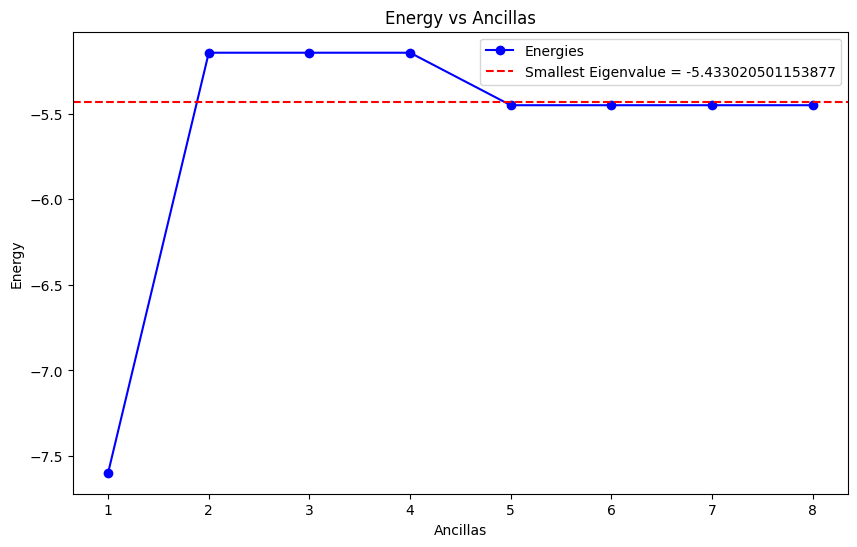

In [11]:
ancillas = np.arange(1, ancilia+1)

# Plotting the energy vs ancillas
plt.figure(figsize=(10, 6))
plt.plot(ancillas, eigen_list, marker='o', linestyle='-', color='b', label='Energies')
plt.axhline(y=smallest_eigenvalue, color='r', linestyle='--', label=f'Smallest Eigenvalue = {smallest_eigenvalue}')

# Labels and title
plt.xlabel('Ancillas')
plt.ylabel('Energy')
plt.title('Energy vs Ancillas')
plt.legend()

plt.show()

In [12]:
# print(qsharp.circuit(qsharp_string))

## Resource Estimates

In [13]:
estimates = qsharp.estimate(qsharp_string,params={"errorBudget": 0.01,
                                  "qubitParams": {"name": "qubit_maj_ns_e6"},
                                  "qecScheme": {"name": "floquet_code"}})
print(estimates.logical_counts)

{'numQubits': 13, 'tCount': 21, 'rotationCount': 7203, 'rotationDepth': 6652, 'cczCount': 0, 'ccixCount': 0, 'measurementCount': 9}
